In [7]:
import pandas as pd

In this post, I'll introduce the econml python package and use it to compare double machine learning and doubly robust learning. I'll look at whether bootstrapping standard errors improves the coverage of confidence intervals, and I'll also look at whether sample size influences estimation accuracy. 



I. Introduction to econml

The econml package was developed by the [ALICE team](https://www.microsoft.com/en-us/research/group/alice/) at microsoft research to facilitate estimation of causal effects. This package builds upon [scikit-learn](https://scikit-learn.org/stable/) and presents several different algorithms for causal inference in one unified framework. 

One of the main reasons to use econml is its integration with scikit-learn. Because econml uses scikit-learn style estimators under the hood, it is easy to evaluate how a model would do if a different estimation style were used by simply swapping out one line in the code.

Another big reason to use econml is that estimators defined in econml all inherit from the same base class. In practice, this means that the methods used to fit models and present treatment effects are the same, regardless of which estimator you are using. So, in this post, switching between double machine learning and doubly robust machine learning is very simple--no additional documentation reading is needed. 

II. Brief introduction to double machine and doubly robust learning. 

Doubly robust machine learning involves fitting two models: one model to predict the treatment X from possible confounders, and another model to predict the outcome Y from X as well as possible confounders. One of the parameters estimated in the second model is used to estimate the average treatment effect of X on Y. This method was developed by [Robins et al.](https://www.tandfonline.com/doi/pdf/10.1080/01621459.1994.10476818?needAccess=true&role=button) in 1994, and has been frequently been used under the name inverse probability weighting. For more on doubly robust machine learning, see [this](https://towardsdatascience.com/doubly-robust-estimators-for-causal-inference-in-statistical-estimation-3c00847e9db) blog post.

Double machine learning involves fitting two models: one model to predict X from confounders and another model to predict Y from the confounders. The residuals of the two models are then used to generate estimates of the causal effect of X on Y. I wrote [this post](https://medium.com/@clementzach_38631/double-machine-learning-for-causal-inference-from-a-partially-linear-model-ada4c39914e3) on double machine learning for more of an overview. 

III. Data generation. 

For this simulation, I generated data in a similar method as my previous [blog post](https://medium.com/@clementzach_38631/causal-inference-with-high-dimensional-data-an-evaluation-of-the-double-machine-learning-algorithm-a882d2135bd5). However, I converted x to a binary variable because doubly robust learning only works with categorical variables. 

In [9]:
import numpy as np
import pandas as pd
def generate_data(n = 400, n_confounders = 10, 
                n_possible_confounders = 300, 
                causal_effect_size = 2, 
                beta_c_x = None, beta_c_y = 1, 
                sd_x_error = None, 
                sd_confounders = 1):
    
    if beta_c_x is None:
        beta_c_x = np.sqrt(1/(n_confounders + 1)) #this lets our x have a variance of 1
    
    if sd_x_error is None:
        sd_x_error = np.sqrt(1/(n_confounders + 1)) #same as above
    
    zero_sequence = np.zeros(n) # a sequence of zeroes the length of our model
    data_dict = dict()
    x = m1 = m2 = zero_sequence
    
    for i in range(n_confounders): # We will have some variables that are true confounders
        c = np.random.normal(size = n, scale = sd_confounders) # Create some variance in the confounder
        m1 = m1 + c*beta_c_x
        m2 = m2 + c*beta_c_y

        data_dict["c" + str(i)] = c
        
    for i in range(n_confounders,n_possible_confounders): #because we are testing sparsity, the rest of the variables will have zero effect. 
        c = np.random.normal(size = n, scale = sd_confounders)

        data_dict["fc" + str(i)] = c #label them as fake
    x = ((np.random.normal(size = n, scale = sd_x_error) + m1 ) > 0) * 1 #convert to binary to make more estimation methods


    y = x * causal_effect_size  + m2 + np.random.normal(size = n, scale = np.std(m2) /10)

    data_dict["x"] = x #replaces the column of zeroes we made before
    data_dict["y"] = y
    
    output_df = pd.DataFrame(data_dict)
    
    return output_df
    

Next, I defined a function to generate an estimate of the average treatment effect from a simulated dataset. As you can see, I can pass in either a LinearDRLearner or a LinearDML object to the function and use the same methods on the object to get simulated effects. 

Both methods generate confidence intervals using traditional statistical techniques ("statsmodels") or with bootstrapping. Here, I allow my function to conduct estimation under both techniques. 

In [10]:
from econml.dr import LinearDRLearner
from econml.dml import LinearDML



estimators_to_test = {
    "dml_linear_bootstrap": [LinearDML(), "bootstrap"],
    "dml_linear_statsmodels": [LinearDML(), "statsmodels"],
    "dr_linear_bootstrap": [LinearDRLearner(), "bootstrap"],
    "dr_linear_statsmodels": [LinearDRLearner(), "statsmodels"]
}

def get_econml_estimate(sim_df, est, inference_method = "bootstrap", sample_size = 0, estimator_name = "", alpha = 0.05):
    est.fit(sim_df["y"], T = sim_df["x"], W=sim_df.drop(["x","y"], axis = 1), inference = inference_method)
    lb, ub = est.ate_interval(alpha=alpha) # OLS confidence intervals
    point_estimate = est.ate()
    return {"lower": lb, "estimate": point_estimate, "upper": ub, "n": sample_size, "estimator_name": estimator_name}
    
    

I'll also define a function to get effects using a standard linear model. 

In [12]:
import statsmodels.api as sm
def get_lm_interval(sim_df, sample_size = 0, alpha = 0.05):
    y = sim_df["y"]
    #sim_df["interaction"] = sim_df["moderator"] * sim_df["x"]
    x = sim_df.drop("y", axis = 1)
    ols_model = sm.OLS(y, x)
    ols_results = ols_model.fit()
    results_df = pd.DataFrame(ols_results.summary(alpha = alpha).tables[1].data)
    results_df.index = results_df[0]
    
    return {"lower": float(results_df.loc["x",5]), 
            "upper": float(results_df.loc["x",6]),
            "estimate": float(results_df.loc["x",1]),
            "n": sample_size, 
            "estimator_name": "standard_linear"
           }
    

In [13]:
def get_lm_interval_small(sim_df, sample_size = 0, alpha = 0.05):
    y = sim_df["y"]
    x = sim_df.drop(["y"] + [col for col in sim_df.columns if col.startswith("f")], axis = 1)
    ols_model = sm.OLS(y, x)
    ols_results = ols_model.fit()
    results_df = pd.DataFrame(ols_results.summary(alpha = alpha).tables[1].data)
    results_df.index = results_df[0]
    
    return {"lower": float(results_df.loc["x",5]), 
            "upper": float(results_df.loc["x",6]),
            "estimate": float(results_df.loc["x",1]),
            "n": sample_size, 
            "estimator_name": "standard_linear_small"
           }

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pickle

all_estimates = []
num_reps = 50
for sample_size in [400, 1600, 6400]:
    print(sample_size)
    for i in range(num_reps):
        sim_df = generate_data(sample_size)
        for estimator_name in estimators_to_test.keys():
            estimate_dict = get_econml_estimate(sim_df, 
                                                estimators_to_test[estimator_name][0], 
                                                estimators_to_test[estimator_name][1], 
                                               sample_size = sample_size,
                                               estimator_name = estimator_name)
            all_estimates.append(estimate_dict)
        all_estimates.append(get_lm_interval_small(sim_df, sample_size = sample_size))
        all_estimates.append(get_lm_interval(sim_df, sample_size = sample_size))
    with open('simulations_4_feb.pickle', 'wb') as handle:
        pickle.dump(all_estimates, handle)  
        
        
            
            
            
        

400
1600
6400


In [15]:
import pickle

with open('all_estimates_4_feb.pickle', 'wb') as handle:
    pickle.dump(all_estimates, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
all_estimates_df = pd.DataFrame(all_estimates)

In [21]:
all_estimates_df["width"] = all_estimates_df["upper"] - all_estimates_df["lower"]

In [23]:
all_estimates_df.head(10)

,lower,estimate,upper,n,estimator_name,width
0,1.773386,1.936886,2.100386,400,dml_linear_bootstrap,0.326999
1,1.813699,1.900463,1.987227,400,dml_linear_statsmodels,0.173528
2,-699.627111,843.452201,2386.531513,400,dr_linear_bootstrap,3086.158625
3,-4117.111658,745.121911,5607.355481,400,dr_linear_statsmodels,9724.467139
4,1.902000,1.951100,2.000000,400,standard_linear_small,0.098000
5,1.841000,1.940600,2.041000,400,standard_linear,0.200000
6,1.827129,2.009646,2.192164,400,dml_linear_bootstrap,0.365035
7,1.964629,2.053412,2.142196,400,dml_linear_statsmodels,0.177567
8,-2318.921907,2.247979,2323.417865,400,dr_linear_bootstrap,4642.339772
9,2.198664,2.270068,2.341472,400,dr_linear_statsmodels,0.142808


In [47]:
all_estimates_df.to_pickle("all_estimates_5_feb.pkl")

In [2]:
import pandas as pd
all_estimates_df = pd.read_pickle("all_estimates_5_feb.pkl")

First, let's look at whether different estimators are biased. 

The bias of an estimator d is defined as the expected value of the estimator minus the true parameter value: 

$$E(\hat{d} - d)$$

For an estimator to be useful, the estimator must have zero bias. If an estimator systematically delivers high or low estimates, that estimator is useless. In the presence of confounding (such as in this situation), it is especially important for the estimator to eliminate bias which originates from confounders.


In [52]:
import numpy as np
## Bias

def bias(x):
    return np.mean(x) - 2
def mse(x):
    return np.mean((np.array(x) - 2) * (np.array(x) - 2))

def sd(x):
    return np.std(x)
    
bias_df = all_estimates_df.groupby(["estimator_name", "n"])["estimate"].agg(
    [bias, sd]
)

bias_df["bias_sd"] = np.round(bias_df["bias"]).astype(str) + np.round(bias_df["sd"]).astype(str)

#

In [53]:
bias_df["bias_sd"] = np.round(bias_df["bias"], 3).astype(str) + " (" + np.round(bias_df["sd"]/ np.sqrt(50), 3).astype(str) + ")"

|    |   A |   B |
|:---|----:|----:|
| a  |   1 |   1 |
| a  |   2 |   2 |
| b  |   3 |   3 |

In [54]:
bias_df = bias_df.reset_index().pivot(index = "estimator_name", columns = "n", values = "bias_sd").reset_index().loc[[0, 2, 4],:]


bias_df["Name"] = ["Double Machine Learning", "Doubly Robust Estimation", "Standard Linear Model"]

bias_df.drop("estimator_name", axis = 1, inplace = True)
bias_df

n,400,1600,6400,Name
0,0.017 (0.009),0.002 (0.003),0.003 (0.002),Double Machine Learning
2,161.905 (108.094),-188.097 (119.696),0.048 (0.027),Doubly Robust Estimation
4,-0.004 (0.008),-0.001 (0.002),0.001 (0.001),Standard Linear Model


Next, let's look at mean squared error, or how close estimates tend to be to the actual parameter value. An estimator with a lower mean squared error is more useful than an estimator with a higher mean squared error because it will estimate the parameter of interest with more precision. 

Mean squared error is defined as:

$$E[(\hat{d} - d)^2]$$



In [168]:
import numpy as np
## mean squared error
mse_df = all_estimates_df.groupby(["estimator_name", "n"])["estimate"].agg([mse]).reset_index()


In [169]:
translation_dict = {"dml_linear_bootstrap": "Double Machine Learning (Bootstrap)",
                    "dml_linear_statsmodels": "Double Machine Learning (Bootstrap)",
                    "dr_linear_bootstrap": "Doubly Robust Estimation (Bootstrap)",
                    "dr_linear_statsmodels": "Doubly Robust Estimation (Bootstrap)",
                    "standard_linear": "Standard Linear Model"
                   }

translation_dict = {"dml_linear_bootstrap": "Double Machine Learning",
                    "dml_linear_statsmodels": "Double Machine Learning",
                    "dr_linear_bootstrap": "Doubly Robust Estimation",
                    "dr_linear_statsmodels": "Doubly Robust Estimation",
                    "standard_linear": "Standard Linear Model"
                   }

In [170]:
mse_df = mse_df.loc[mse_df["estimator_name"].isin(
    ["dml_linear_statsmodels", "dr_linear_statsmodels", "standard_linear"]),:]

In [171]:
mse_df["Estimator"] = mse_df["estimator_name"].apply(lambda x: translation_dict[x])

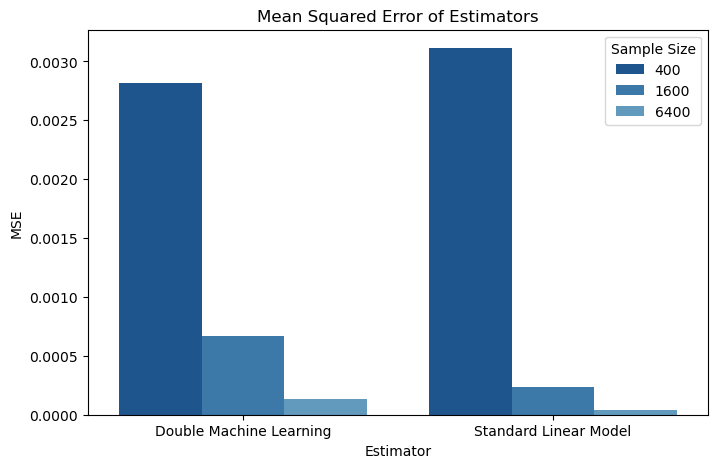

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

mse_df["MSE"] = mse_df["mse"]

mse_df["Sample Size"] = mse_df["n"]
sns.barplot(data=mse_df.loc[ (mse_df["estimator_name"] != "dr_linear_statsmodels"), :], 
            x="Estimator", y="MSE", hue="Sample Size",
           palette = sns.color_palette("Blues_r"))
plt.title("Mean Squared Error of Estimators")
plt.show()


In [124]:
mse_df["mse"]  = mse_df["mse"].astype(float).round(6).astype(str)
mse_df.pivot(index = "Name", columns = "n", values = "mse").reset_index()

n,Name,400,1600,6400
0,Double Machine Learning,0.002816,0.000671,0.000133
1,Doubly Robust Estimation,1778149.937155,376383.085348,0.016019
2,Standard Linear Model,0.003114,0.000235,4.2e-05


Finally, let's look at coverage probabilities. We calculated 95% confidence intervals for our estimates using both bootstrap estimation and estimation based on a known distribution. In bootstrap variance estimation, the dataset is duplicated many times by sampling with replacement and the quantiles from the distribution of these estimations are used to determine confidence intervals. In estimation based on a known distribution, statistical theory is used to determine what the variance of the estimate should be, and confidence intervals are generated from the normal or t distribution.

In [143]:
translation_dict = {"dml_linear_bootstrap": "Double ML\n (Bootstrap)",
                    "dml_linear_statsmodels": "Double ML\n (Non-Bootstrap)",
                    "dr_linear_bootstrap": "Doubly Robust\n(Bootstrap)",
                    "dr_linear_statsmodels": "Doubly Robust\n(Non-Bootstrap)",
                    "standard_linear": "Standard Linear\nModel"
                   }

In [144]:
import numpy as np
## coverage

all_estimates_df["covered"] = (all_estimates_df["upper"] > 2) & (all_estimates_df["lower"] < 2)
coverage_df = all_estimates_df.groupby(["estimator_name", "n"])["covered"].agg("mean").reset_index()

coverage_df = coverage_df.loc[coverage_df["estimator_name"] != "standard_linear_small"]

In [145]:
coverage_df

,estimator_name,n,covered
0,dml_linear_bootstrap,400,0.98
1,dml_linear_bootstrap,1600,0.96
2,dml_linear_bootstrap,6400,1.00
3,dml_linear_statsmodels,400,0.90
4,dml_linear_statsmodels,1600,0.88
5,dml_linear_statsmodels,6400,0.96
6,dr_linear_bootstrap,400,0.98
7,dr_linear_bootstrap,1600,0.96
8,dr_linear_bootstrap,6400,1.00
9,dr_linear_statsmodels,400,0.64


In [161]:
coverage_df["Estimator"] = coverage_df["estimator_name"].apply(lambda x: translation_dict[x])


In [147]:
coverage_df["Sample Size"] = coverage_df["n"]

coverage_df["Coverage Probability"] = coverage_df["covered"]

In [154]:
dir(ax)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_

In [156]:
ax.get_xticklabels()

[Text(0, 0, 'Double ML\n (Bootstrap)'),
 Text(1, 0, 'Double ML\n (Non-Bootstrap)'),
 Text(2, 0, 'Doubly Robust\n(Bootstrap)'),
 Text(3, 0, 'Doubly Robust\n(Non-Bootstrap)'),
 Text(4, 0, 'Standard Linear\nModel')]

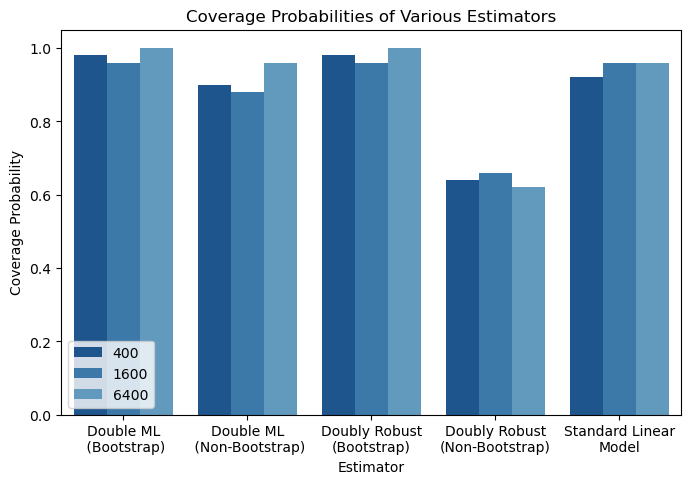

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 5]

ax = sns.barplot(data=coverage_df, 
            x="Estimator", y="Coverage Probability", hue="Sample Size",
           palette = sns.color_palette("Blues_r"))

plt.legend(loc='lower left')
plt.title("Coverage Probabilities of Various Estimators")
#ax.set_xticklabels(ax rotation=0, fontsize=8)
plt.show()

To summarize, here are my main conclusions from this simulation: 

1. econml is a great package for causal inference  
2. Bootstrapping can be used to generate accurate coverage probabilities even when traditional statistical estimation fails
3. Double Machine Learning out-performs doubly robust estimation in conditions of sparsity and low sample size

In [33]:
from scipy.stats import binom

In [43]:
observed_list = []
prob_list = []
for num_observed in range(30, 51):
    observed_list.append(num_observed)
    if num_observed < 0.95 * 50:
    
        prob_list.append(binom.cdf(num_observed, 50, .95))
        
    else:
        prob_list.append(1 - binom.cdf(num_observed -1, 50, .95))

In [46]:
pd.DataFrame({"probs": np.array(prob_list) * 16, "observed": observed_list})

,probs,observed
0,1.668198e-12,30
1,2.058903e-11,31
2,2.340397e-10,32
3,2.446165e-09,33
4,2.346135e-08,34
5,2.059933e-07,35
6,1.651038e-06,36
7,1.203974e-05,37
8,7.956627e-05,38
9,4.743368e-04,39
